# Loan Classification using Logistic Regression and Keras

### Project Overview
The objective for this project is to utilize Logistic Regression ML algorithm to build a classification prediction model using customer personal loan data. 

### Dataset Info:
Dataset is a random listing of personal loans along with customer information.

The 'personal_loan_info.csv'file contains a listing of customer loan info with a focus on loan status.


| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| loan_id        | Unique loan id                                                                        |
| loan_status    | Status of loan(Current, Collections, Paid, Late)                                      |
| prin_balance   | Principle loan balance                                                                |
| loan_term      | Loan origination terms(annual)                                                        |
| loan_orig_date | Origination date when the loan was generated                                          |
| loan_due_date  | Due date for next loan payment or last payment                                        |
| customer_age   | Borrower age at time of loan generation                                               |
| customer_income| Borrower income noted from loan application                                           |
| customer_gender| Borrower gender                                                                       |
| customer_edu   | Borrower latest education noted from loan application                                 |

### Python library/module setup

In [97]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Import 'personal_loan_info.csv'

In [72]:
df = pd.read_csv(r'personal_loan_info.csv')
print(df)

     loan_id  loan_status  principal_balance  loan_term loan_orig_date  \
0          1      Current              62868         15       1/1/2014   
1          2  Collections              29152         13     12/30/2015   
2          3         Paid              69370         13     10/11/2015   
3          4         Late              67059         14      6/30/2015   
4          5      Current              78181         13      3/16/2016   
..       ...          ...                ...        ...            ...   
123      124         Late              47660          8      8/29/2015   
124      125      Current              38488         13      2/23/2016   
125      126  Collections               1222         14      1/27/2015   
126      127         Paid              20390          8      1/30/2015   
127      128         Late              54678          6      5/23/2015   

    loan_due_date  customer_age customer_gender  customer_income customer_edu  
0        2/6/2020            38

In [73]:
df.shape

(128, 10)

### Convert csv date fields to datetime format

In [74]:
df['loan_orig_date'] = pd.to_datetime(df['loan_orig_date'])
df['loan_due_date'] = pd.to_datetime(df['loan_due_date'])
df.head()

,loan_id,loan_status,principal_balance,loan_term,loan_orig_date,loan_due_date,customer_age,customer_gender,customer_income,customer_edu
0,1,Current,62868,15,2014-01-01,2020-02-06,38,F,38877,High School
1,2,Collections,29152,13,2015-12-30,2016-12-29,46,F,13082,Associates
2,3,Paid,69370,13,2015-10-11,2020-01-27,51,F,49742,Bachelor
3,4,Late,67059,14,2015-06-30,2020-01-07,22,F,50453,Masters
4,5,Current,78181,13,2016-03-16,2020-02-06,59,F,26114,HighSchool


### Data Inspection

In [75]:
df.describe()

,loan_id,principal_balance,loan_term,customer_age,customer_income
count,128.000000,128.00000,128.000000,128.00000,128.000000
mean,64.500000,42662.03125,8.648438,44.46875,54991.718750
std,37.094474,22042.35593,3.782658,13.39934,26158.223092
min,1.000000,1222.00000,3.000000,22.00000,10279.000000
25%,32.750000,23065.50000,5.000000,33.75000,33198.500000
50%,64.500000,45162.50000,8.000000,44.50000,50735.000000
75%,96.250000,60372.75000,12.000000,55.00000,77374.500000
max,128.000000,79856.00000,15.000000,68.00000,99997.000000


In [76]:
(df.dtypes)

loan_id                       int64
loan_status                  object
principal_balance             int64
loan_term                     int64
loan_orig_date       datetime64[ns]
loan_due_date        datetime64[ns]
customer_age                  int64
customer_gender              object
customer_income               int64
customer_edu                 object
dtype: object

Check for missing values

In [77]:
missing_count = df.isnull().sum()/len(df)*100
print(missing_count)

loan_id              0.0
loan_status          0.0
principal_balance    0.0
loan_term            0.0
loan_orig_date       0.0
loan_due_date        0.0
customer_age         0.0
customer_gender      0.0
customer_income      0.0
customer_edu         0.0
dtype: float64


Observation: no missing values within the dataset

In [78]:
df['loan_status'].value_counts()

Late           32
Current        32
Paid           32
Collections    32
Name: loan_status, dtype: int64

### Visualize loan data

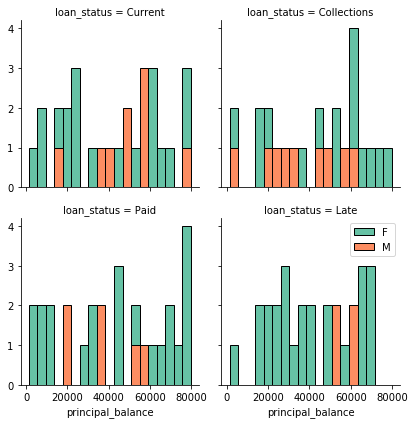

In [79]:
bins = np.linspace(df.principal_balance.min(), df.principal_balance.max(), 20)
g = sns.FacetGrid(df, col='loan_status', hue='customer_gender', palette='Set2', col_wrap=2)
g.map(plt.hist, 'principal_balance', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

Observation: equal distributions for most of the loan status, with slightly more female accounts in the 'Paid' and 'Late' status.

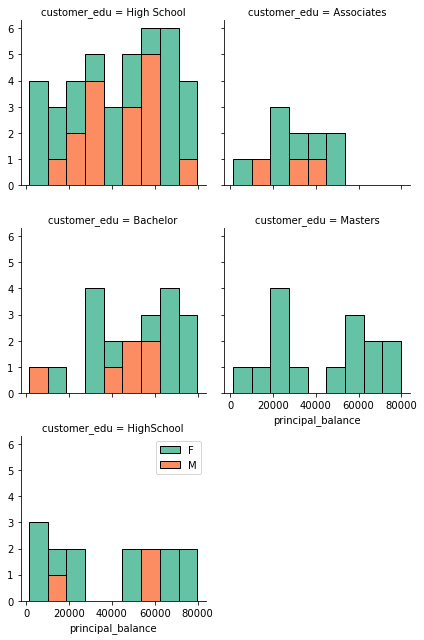

In [80]:
bins = np.linspace(df.principal_balance.min(), df.principal_balance.max(), 10)
g = sns.FacetGrid(df, col='customer_edu', hue='customer_gender', palette='Set2', col_wrap=2)
g.map(plt.hist, 'principal_balance', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

Observation: equal distributions for customer education being High School, only customers with Masters education are female.

In [81]:
df.groupby(['customer_gender'])['loan_status'].value_counts(normalize=True)

customer_gender  loan_status
F                Late           0.280000
                 Paid           0.260000
                 Collections    0.230000
                 Current        0.230000
M                Collections    0.321429
                 Current        0.321429
                 Paid           0.214286
                 Late           0.142857
Name: loan_status, dtype: float64

Observation: distributions look somewhat evenly spread out with males showing half as late as females...but higher volumes in 'Collections'

### Feature Processing
Create new dataframe with interval features only

In [82]:
df

,loan_id,loan_status,principal_balance,loan_term,loan_orig_date,loan_due_date,customer_age,customer_gender,customer_income,customer_edu
0,1,Current,62868,15,2014-01-01,2020-02-06,38,F,38877,High School
1,2,Collections,29152,13,2015-12-30,2016-12-29,46,F,13082,Associates
2,3,Paid,69370,13,2015-10-11,2020-01-27,51,F,49742,Bachelor
3,4,Late,67059,14,2015-06-30,2020-01-07,22,F,50453,Masters
4,5,Current,78181,13,2016-03-16,2020-02-06,59,F,26114,HighSchool
...,...,...,...,...,...,...,...,...,...,...
123,124,Late,47660,8,2015-08-29,2020-01-07,43,F,45650,High School
124,125,Current,38488,13,2016-02-23,2020-02-06,53,F,19949,High School
125,126,Collections,1222,14,2015-01-27,2016-01-27,50,F,20216,High School
126,127,Paid,20390,8,2015-01-30,2020-01-27,36,M,31523,High School


In [83]:
df = pd.concat([df, pd.get_dummies(df['loan_status']),
                    pd.get_dummies(df['customer_edu'])]
                    ,axis=1)

In [84]:
df['customer_gender'].replace(to_replace=['M','F'], value=[0,1],inplace=True)

In [85]:
df

,loan_id,loan_status,principal_balance,loan_term,loan_orig_date,loan_due_date,customer_age,customer_gender,customer_income,customer_edu,Collections,Current,Late,Paid,Associates,Bachelor,High School,HighSchool,Masters
0,1,Current,62868,15,2014-01-01,2020-02-06,38,1,38877,High School,0,1,0,0,0,0,1,0,0
1,2,Collections,29152,13,2015-12-30,2016-12-29,46,1,13082,Associates,1,0,0,0,1,0,0,0,0
2,3,Paid,69370,13,2015-10-11,2020-01-27,51,1,49742,Bachelor,0,0,0,1,0,1,0,0,0
3,4,Late,67059,14,2015-06-30,2020-01-07,22,1,50453,Masters,0,0,1,0,0,0,0,0,1
4,5,Current,78181,13,2016-03-16,2020-02-06,59,1,26114,HighSchool,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,Late,47660,8,2015-08-29,2020-01-07,43,1,45650,High School,0,0,1,0,0,0,1,0,0
124,125,Current,38488,13,2016-02-23,2020-02-06,53,1,19949,High School,0,1,0,0,0,0,1,0,0
125,126,Collections,1222,14,2015-01-27,2016-01-27,50,1,20216,High School,1,0,0,0,0,0,1,0,0
126,127,Paid,20390,8,2015-01-30,2020-01-27,36,0,31523,High School,0,0,0,1,0,0,1,0,0


In [86]:
y = df['customer_gender'].values
X = df.drop(columns=['customer_edu','loan_status','loan_orig_date','loan_due_date'])
n_cols = X.shape[1]

In [87]:
print("y values: ", y[0:5])
print("X values: ", X[0:5])
print("n_cols:  ", n_cols)

y values:  [1 1 1 1 1]
X values:     loan_id  principal_balance  loan_term  customer_age  customer_gender  \
0        1              62868         15            38                1   
1        2              29152         13            46                1   
2        3              69370         13            51                1   
3        4              67059         14            22                1   
4        5              78181         13            59                1   

   customer_income  Collections  Current  Late  Paid  Associates  Bachelor  \
0            38877            0        1     0     0           0         0   
1            13082            1        0     0     0           1         0   
2            49742            0        0     0     1           0         1   
3            50453            0        0     1     0           0         0   
4            26114            0        1     0     0           0         0   

   High School  HighSchool  Masters  
0       

Evaluate feature dataset and validate cat features were converted

In [94]:
X_norm = ((X - X.mean()) / X.std())
X_norm.head()

,loan_id,principal_balance,loan_term,customer_age,customer_gender,customer_income,Collections,Current,Late,Paid,Associates,Bachelor,High School,HighSchool,Masters
0,-1.711845,0.916688,1.679127,-0.482766,0.527079,-0.616048,-0.575091,1.725272,-0.575091,-0.575091,-0.349067,-0.502902,1.129455,-0.389816,-0.362914
1,-1.684887,-0.612912,1.150398,0.114278,0.527079,-1.602162,1.725272,-0.575091,-0.575091,-0.575091,2.842401,-0.502902,-0.878465,-0.389816,-0.362914
2,-1.657929,1.211666,1.150398,0.487431,0.527079,-0.200691,-0.575091,-0.575091,-0.575091,1.725272,-0.349067,1.972924,-0.878465,-0.389816,-0.362914
3,-1.630971,1.106822,1.414762,-1.676855,0.527079,-0.173510,-0.575091,-0.575091,1.725272,-0.575091,-0.349067,-0.502902,-0.878465,-0.389816,2.733949
4,-1.604013,1.611396,1.150398,1.084475,0.527079,-1.103963,-0.575091,1.725272,-0.575091,-0.575091,-0.349067,-0.502902,-0.878465,2.545270,-0.362914


### Build Neural Network

In [95]:
# define regression model
def regression_model():
    # create model
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

### Train and Test Network

In [98]:
Ks = 50
lr_list = []
for n in range(1,Ks):
    # Split the data into training and test sets
    X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size = 0.3,)
    # Build the model
    model = regression_model()
    # Fit the model  
    model.fit(X_train, y_train, validation_split=0.3, epochs=100, verbose=2)
    # MSE prediction values 
    pred= model.predict(X_test)
    pred_mse = np.sqrt(mean_squared_error(y_test,pred)) 
    # Append model mse to lr_list
    lr_list.append(pred_mse) 

Train on 62 samples, validate on 27 samples
Epoch 1/100
 - 0s - loss: 0.9363 - val_loss: 0.8639
Epoch 2/100
 - 0s - loss: 0.8884 - val_loss: 0.8088
Epoch 3/100
 - 0s - loss: 0.8372 - val_loss: 0.7591
Epoch 4/100
 - 0s - loss: 0.7980 - val_loss: 0.7111
Epoch 5/100
 - 0s - loss: 0.7577 - val_loss: 0.6648
Epoch 6/100
 - 0s - loss: 0.7210 - val_loss: 0.6228
Epoch 7/100
 - 0s - loss: 0.6809 - val_loss: 0.5849
Epoch 8/100
 - 0s - loss: 0.6456 - val_loss: 0.5499
Epoch 9/100
 - 0s - loss: 0.6120 - val_loss: 0.5180
Epoch 10/100
 - 0s - loss: 0.5812 - val_loss: 0.4874
Epoch 11/100
 - 0s - loss: 0.5527 - val_loss: 0.4598
Epoch 12/100
 - 0s - loss: 0.5271 - val_loss: 0.4337
Epoch 13/100
 - 0s - loss: 0.5044 - val_loss: 0.4092
Epoch 14/100
 - 0s - loss: 0.4830 - val_loss: 0.3865
Epoch 15/100
 - 0s - loss: 0.4619 - val_loss: 0.3654
Epoch 16/100
 - 0s - loss: 0.4436 - val_loss: 0.3463
Epoch 17/100
 - 0s - loss: 0.4271 - val_loss: 0.3286
Epoch 18/100
 - 0s - loss: 0.4096 - val_loss: 0.3128
Epoch 19/10

Epoch 55/100
 - 0s - loss: 0.0885 - val_loss: 0.1973
Epoch 56/100
 - 0s - loss: 0.0857 - val_loss: 0.1925
Epoch 57/100
 - 0s - loss: 0.0829 - val_loss: 0.1880
Epoch 58/100
 - 0s - loss: 0.0802 - val_loss: 0.1835
Epoch 59/100
 - 0s - loss: 0.0776 - val_loss: 0.1790
Epoch 60/100
 - 0s - loss: 0.0749 - val_loss: 0.1746
Epoch 61/100
 - 0s - loss: 0.0725 - val_loss: 0.1705
Epoch 62/100
 - 0s - loss: 0.0700 - val_loss: 0.1668
Epoch 63/100
 - 0s - loss: 0.0677 - val_loss: 0.1633
Epoch 64/100
 - 0s - loss: 0.0653 - val_loss: 0.1600
Epoch 65/100
 - 0s - loss: 0.0633 - val_loss: 0.1568
Epoch 66/100
 - 0s - loss: 0.0610 - val_loss: 0.1538
Epoch 67/100
 - 0s - loss: 0.0591 - val_loss: 0.1509
Epoch 68/100
 - 0s - loss: 0.0569 - val_loss: 0.1481
Epoch 69/100
 - 0s - loss: 0.0551 - val_loss: 0.1454
Epoch 70/100
 - 0s - loss: 0.0530 - val_loss: 0.1429
Epoch 71/100
 - 0s - loss: 0.0510 - val_loss: 0.1405
Epoch 72/100
 - 0s - loss: 0.0495 - val_loss: 0.1380
Epoch 73/100
 - 0s - loss: 0.0475 - val_loss: 

Epoch 9/100
 - 0s - loss: 0.6773 - val_loss: 0.5841
Epoch 10/100
 - 0s - loss: 0.6535 - val_loss: 0.5687
Epoch 11/100
 - 0s - loss: 0.6321 - val_loss: 0.5534
Epoch 12/100
 - 0s - loss: 0.6076 - val_loss: 0.5387
Epoch 13/100
 - 0s - loss: 0.5859 - val_loss: 0.5247
Epoch 14/100
 - 0s - loss: 0.5634 - val_loss: 0.5114
Epoch 15/100
 - 0s - loss: 0.5418 - val_loss: 0.4982
Epoch 16/100
 - 0s - loss: 0.5203 - val_loss: 0.4856
Epoch 17/100
 - 0s - loss: 0.4974 - val_loss: 0.4736
Epoch 18/100
 - 0s - loss: 0.4750 - val_loss: 0.4627
Epoch 19/100
 - 0s - loss: 0.4536 - val_loss: 0.4526
Epoch 20/100
 - 0s - loss: 0.4314 - val_loss: 0.4434
Epoch 21/100
 - 0s - loss: 0.4097 - val_loss: 0.4350
Epoch 22/100
 - 0s - loss: 0.3885 - val_loss: 0.4278
Epoch 23/100
 - 0s - loss: 0.3652 - val_loss: 0.4218
Epoch 24/100
 - 0s - loss: 0.3455 - val_loss: 0.4155
Epoch 25/100
 - 0s - loss: 0.3226 - val_loss: 0.4085
Epoch 26/100
 - 0s - loss: 0.3025 - val_loss: 0.4026
Epoch 27/100
 - 0s - loss: 0.2825 - val_loss: 0

Epoch 63/100
 - 0s - loss: 0.0641 - val_loss: 0.1047
Epoch 64/100
 - 0s - loss: 0.0621 - val_loss: 0.1040
Epoch 65/100
 - 0s - loss: 0.0604 - val_loss: 0.1033
Epoch 66/100
 - 0s - loss: 0.0587 - val_loss: 0.1027
Epoch 67/100
 - 0s - loss: 0.0574 - val_loss: 0.1022
Epoch 68/100
 - 0s - loss: 0.0558 - val_loss: 0.1018
Epoch 69/100
 - 0s - loss: 0.0543 - val_loss: 0.1014
Epoch 70/100
 - 0s - loss: 0.0529 - val_loss: 0.1012
Epoch 71/100
 - 0s - loss: 0.0517 - val_loss: 0.1010
Epoch 72/100
 - 0s - loss: 0.0504 - val_loss: 0.1008
Epoch 73/100
 - 0s - loss: 0.0490 - val_loss: 0.1004
Epoch 74/100
 - 0s - loss: 0.0480 - val_loss: 0.1001
Epoch 75/100
 - 0s - loss: 0.0468 - val_loss: 0.0998
Epoch 76/100
 - 0s - loss: 0.0458 - val_loss: 0.0994
Epoch 77/100
 - 0s - loss: 0.0448 - val_loss: 0.0990
Epoch 78/100
 - 0s - loss: 0.0437 - val_loss: 0.0986
Epoch 79/100
 - 0s - loss: 0.0425 - val_loss: 0.0981
Epoch 80/100
 - 0s - loss: 0.0415 - val_loss: 0.0976
Epoch 81/100
 - 0s - loss: 0.0405 - val_loss: 

Epoch 17/100
 - 0s - loss: 0.1677 - val_loss: 0.3096
Epoch 18/100
 - 0s - loss: 0.1579 - val_loss: 0.3039
Epoch 19/100
 - 0s - loss: 0.1512 - val_loss: 0.2982
Epoch 20/100
 - 0s - loss: 0.1430 - val_loss: 0.2917
Epoch 21/100
 - 0s - loss: 0.1374 - val_loss: 0.2849
Epoch 22/100
 - 0s - loss: 0.1299 - val_loss: 0.2771
Epoch 23/100
 - 0s - loss: 0.1236 - val_loss: 0.2689
Epoch 24/100
 - 0s - loss: 0.1172 - val_loss: 0.2602
Epoch 25/100
 - 0s - loss: 0.1104 - val_loss: 0.2515
Epoch 26/100
 - 0s - loss: 0.1048 - val_loss: 0.2430
Epoch 27/100
 - 0s - loss: 0.0987 - val_loss: 0.2350
Epoch 28/100
 - 0s - loss: 0.0936 - val_loss: 0.2272
Epoch 29/100
 - 0s - loss: 0.0881 - val_loss: 0.2198
Epoch 30/100
 - 0s - loss: 0.0837 - val_loss: 0.2127
Epoch 31/100
 - 0s - loss: 0.0795 - val_loss: 0.2060
Epoch 32/100
 - 0s - loss: 0.0755 - val_loss: 0.2000
Epoch 33/100
 - 0s - loss: 0.0716 - val_loss: 0.1941
Epoch 34/100
 - 0s - loss: 0.0681 - val_loss: 0.1886
Epoch 35/100
 - 0s - loss: 0.0646 - val_loss: 

Epoch 71/100
 - 0s - loss: 0.0643 - val_loss: 0.1292
Epoch 72/100
 - 0s - loss: 0.0632 - val_loss: 0.1281
Epoch 73/100
 - 0s - loss: 0.0621 - val_loss: 0.1270
Epoch 74/100
 - 0s - loss: 0.0611 - val_loss: 0.1258
Epoch 75/100
 - 0s - loss: 0.0600 - val_loss: 0.1247
Epoch 76/100
 - 0s - loss: 0.0589 - val_loss: 0.1236
Epoch 77/100
 - 0s - loss: 0.0578 - val_loss: 0.1225
Epoch 78/100
 - 0s - loss: 0.0568 - val_loss: 0.1214
Epoch 79/100
 - 0s - loss: 0.0559 - val_loss: 0.1204
Epoch 80/100
 - 0s - loss: 0.0547 - val_loss: 0.1193
Epoch 81/100
 - 0s - loss: 0.0539 - val_loss: 0.1183
Epoch 82/100
 - 0s - loss: 0.0529 - val_loss: 0.1172
Epoch 83/100
 - 0s - loss: 0.0520 - val_loss: 0.1162
Epoch 84/100
 - 0s - loss: 0.0512 - val_loss: 0.1151
Epoch 85/100
 - 0s - loss: 0.0504 - val_loss: 0.1141
Epoch 86/100
 - 0s - loss: 0.0496 - val_loss: 0.1131
Epoch 87/100
 - 0s - loss: 0.0487 - val_loss: 0.1122
Epoch 88/100
 - 0s - loss: 0.0479 - val_loss: 0.1113
Epoch 89/100
 - 0s - loss: 0.0472 - val_loss: 

Epoch 25/100
 - 0s - loss: 0.2334 - val_loss: 0.3074
Epoch 26/100
 - 0s - loss: 0.2258 - val_loss: 0.3001
Epoch 27/100
 - 0s - loss: 0.2192 - val_loss: 0.2934
Epoch 28/100
 - 0s - loss: 0.2131 - val_loss: 0.2870
Epoch 29/100
 - 0s - loss: 0.2075 - val_loss: 0.2812
Epoch 30/100
 - 0s - loss: 0.2017 - val_loss: 0.2757
Epoch 31/100
 - 0s - loss: 0.1957 - val_loss: 0.2707
Epoch 32/100
 - 0s - loss: 0.1911 - val_loss: 0.2658
Epoch 33/100
 - 0s - loss: 0.1858 - val_loss: 0.2613
Epoch 34/100
 - 0s - loss: 0.1814 - val_loss: 0.2570
Epoch 35/100
 - 0s - loss: 0.1765 - val_loss: 0.2528
Epoch 36/100
 - 0s - loss: 0.1723 - val_loss: 0.2489
Epoch 37/100
 - 0s - loss: 0.1679 - val_loss: 0.2452
Epoch 38/100
 - 0s - loss: 0.1642 - val_loss: 0.2418
Epoch 39/100
 - 0s - loss: 0.1606 - val_loss: 0.2385
Epoch 40/100
 - 0s - loss: 0.1568 - val_loss: 0.2353
Epoch 41/100
 - 0s - loss: 0.1536 - val_loss: 0.2322
Epoch 42/100
 - 0s - loss: 0.1507 - val_loss: 0.2291
Epoch 43/100
 - 0s - loss: 0.1480 - val_loss: 

Epoch 79/100
 - 0s - loss: 0.0633 - val_loss: 0.1540
Epoch 80/100
 - 0s - loss: 0.0612 - val_loss: 0.1535
Epoch 81/100
 - 0s - loss: 0.0593 - val_loss: 0.1531
Epoch 82/100
 - 0s - loss: 0.0575 - val_loss: 0.1525
Epoch 83/100
 - 0s - loss: 0.0559 - val_loss: 0.1521
Epoch 84/100
 - 0s - loss: 0.0544 - val_loss: 0.1515
Epoch 85/100
 - 0s - loss: 0.0529 - val_loss: 0.1510
Epoch 86/100
 - 0s - loss: 0.0515 - val_loss: 0.1504
Epoch 87/100
 - 0s - loss: 0.0503 - val_loss: 0.1498
Epoch 88/100
 - 0s - loss: 0.0490 - val_loss: 0.1490
Epoch 89/100
 - 0s - loss: 0.0478 - val_loss: 0.1484
Epoch 90/100
 - 0s - loss: 0.0467 - val_loss: 0.1477
Epoch 91/100
 - 0s - loss: 0.0457 - val_loss: 0.1470
Epoch 92/100
 - 0s - loss: 0.0447 - val_loss: 0.1465
Epoch 93/100
 - 0s - loss: 0.0438 - val_loss: 0.1460
Epoch 94/100
 - 0s - loss: 0.0429 - val_loss: 0.1456
Epoch 95/100
 - 0s - loss: 0.0419 - val_loss: 0.1453
Epoch 96/100
 - 0s - loss: 0.0411 - val_loss: 0.1450
Epoch 97/100
 - 0s - loss: 0.0403 - val_loss: 

Epoch 33/100
 - 0s - loss: 0.1404 - val_loss: 0.1749
Epoch 34/100
 - 0s - loss: 0.1363 - val_loss: 0.1707
Epoch 35/100
 - 0s - loss: 0.1310 - val_loss: 0.1656
Epoch 36/100
 - 0s - loss: 0.1253 - val_loss: 0.1608
Epoch 37/100
 - 0s - loss: 0.1210 - val_loss: 0.1559
Epoch 38/100
 - 0s - loss: 0.1159 - val_loss: 0.1516
Epoch 39/100
 - 0s - loss: 0.1115 - val_loss: 0.1478
Epoch 40/100
 - 0s - loss: 0.1078 - val_loss: 0.1444
Epoch 41/100
 - 0s - loss: 0.1039 - val_loss: 0.1415
Epoch 42/100
 - 0s - loss: 0.1011 - val_loss: 0.1390
Epoch 43/100
 - 0s - loss: 0.0983 - val_loss: 0.1367
Epoch 44/100
 - 0s - loss: 0.0958 - val_loss: 0.1344
Epoch 45/100
 - 0s - loss: 0.0929 - val_loss: 0.1325
Epoch 46/100
 - 0s - loss: 0.0905 - val_loss: 0.1307
Epoch 47/100
 - 0s - loss: 0.0884 - val_loss: 0.1290
Epoch 48/100
 - 0s - loss: 0.0861 - val_loss: 0.1274
Epoch 49/100
 - 0s - loss: 0.0838 - val_loss: 0.1253
Epoch 50/100
 - 0s - loss: 0.0819 - val_loss: 0.1233
Epoch 51/100
 - 0s - loss: 0.0797 - val_loss: 

Epoch 87/100
 - 0s - loss: 0.0316 - val_loss: 0.2761
Epoch 88/100
 - 0s - loss: 0.0311 - val_loss: 0.2751
Epoch 89/100
 - 0s - loss: 0.0305 - val_loss: 0.2741
Epoch 90/100
 - 0s - loss: 0.0298 - val_loss: 0.2721
Epoch 91/100
 - 0s - loss: 0.0292 - val_loss: 0.2706
Epoch 92/100
 - 0s - loss: 0.0287 - val_loss: 0.2687
Epoch 93/100
 - 0s - loss: 0.0282 - val_loss: 0.2682
Epoch 94/100
 - 0s - loss: 0.0275 - val_loss: 0.2669
Epoch 95/100
 - 0s - loss: 0.0270 - val_loss: 0.2663
Epoch 96/100
 - 0s - loss: 0.0264 - val_loss: 0.2657
Epoch 97/100
 - 0s - loss: 0.0259 - val_loss: 0.2649
Epoch 98/100
 - 0s - loss: 0.0255 - val_loss: 0.2648
Epoch 99/100
 - 0s - loss: 0.0249 - val_loss: 0.2640
Epoch 100/100
 - 0s - loss: 0.0245 - val_loss: 0.2634
Train on 62 samples, validate on 27 samples
Epoch 1/100
 - 0s - loss: 0.6058 - val_loss: 0.6198
Epoch 2/100
 - 0s - loss: 0.5885 - val_loss: 0.5952
Epoch 3/100
 - 0s - loss: 0.5689 - val_loss: 0.5710
Epoch 4/100
 - 0s - loss: 0.5481 - val_loss: 0.5463
Epoch

Epoch 41/100
 - 0s - loss: 0.1143 - val_loss: 0.1773
Epoch 42/100
 - 0s - loss: 0.1112 - val_loss: 0.1741
Epoch 43/100
 - 0s - loss: 0.1082 - val_loss: 0.1711
Epoch 44/100
 - 0s - loss: 0.1052 - val_loss: 0.1683
Epoch 45/100
 - 0s - loss: 0.1025 - val_loss: 0.1656
Epoch 46/100
 - 0s - loss: 0.0998 - val_loss: 0.1630
Epoch 47/100
 - 0s - loss: 0.0974 - val_loss: 0.1602
Epoch 48/100
 - 0s - loss: 0.0951 - val_loss: 0.1578
Epoch 49/100
 - 0s - loss: 0.0926 - val_loss: 0.1552
Epoch 50/100
 - 0s - loss: 0.0902 - val_loss: 0.1528
Epoch 51/100
 - 0s - loss: 0.0880 - val_loss: 0.1505
Epoch 52/100
 - 0s - loss: 0.0859 - val_loss: 0.1486
Epoch 53/100
 - 0s - loss: 0.0839 - val_loss: 0.1467
Epoch 54/100
 - 0s - loss: 0.0819 - val_loss: 0.1449
Epoch 55/100
 - 0s - loss: 0.0800 - val_loss: 0.1431
Epoch 56/100
 - 0s - loss: 0.0783 - val_loss: 0.1415
Epoch 57/100
 - 0s - loss: 0.0767 - val_loss: 0.1399
Epoch 58/100
 - 0s - loss: 0.0750 - val_loss: 0.1384
Epoch 59/100
 - 0s - loss: 0.0733 - val_loss: 

Epoch 95/100
 - 0s - loss: 0.0150 - val_loss: 0.0867
Epoch 96/100
 - 0s - loss: 0.0146 - val_loss: 0.0865
Epoch 97/100
 - 0s - loss: 0.0142 - val_loss: 0.0864
Epoch 98/100
 - 0s - loss: 0.0137 - val_loss: 0.0863
Epoch 99/100
 - 0s - loss: 0.0133 - val_loss: 0.0862
Epoch 100/100
 - 0s - loss: 0.0129 - val_loss: 0.0862
Train on 62 samples, validate on 27 samples
Epoch 1/100
 - 0s - loss: 0.8110 - val_loss: 0.7455
Epoch 2/100
 - 0s - loss: 0.7703 - val_loss: 0.7112
Epoch 3/100
 - 0s - loss: 0.7268 - val_loss: 0.6789
Epoch 4/100
 - 0s - loss: 0.6836 - val_loss: 0.6481
Epoch 5/100
 - 0s - loss: 0.6430 - val_loss: 0.6201
Epoch 6/100
 - 0s - loss: 0.6077 - val_loss: 0.5920
Epoch 7/100
 - 0s - loss: 0.5738 - val_loss: 0.5650
Epoch 8/100
 - 0s - loss: 0.5424 - val_loss: 0.5389
Epoch 9/100
 - 0s - loss: 0.5104 - val_loss: 0.5134
Epoch 10/100
 - 0s - loss: 0.4805 - val_loss: 0.4896
Epoch 11/100
 - 0s - loss: 0.4528 - val_loss: 0.4683
Epoch 12/100
 - 0s - loss: 0.4282 - val_loss: 0.4477
Epoch 13/1

Epoch 49/100
 - 0s - loss: 0.2434 - val_loss: 0.3005
Epoch 50/100
 - 0s - loss: 0.2378 - val_loss: 0.2935
Epoch 51/100
 - 0s - loss: 0.2327 - val_loss: 0.2867
Epoch 52/100
 - 0s - loss: 0.2272 - val_loss: 0.2804
Epoch 53/100
 - 0s - loss: 0.2226 - val_loss: 0.2743
Epoch 54/100
 - 0s - loss: 0.2174 - val_loss: 0.2683
Epoch 55/100
 - 0s - loss: 0.2127 - val_loss: 0.2630
Epoch 56/100
 - 0s - loss: 0.2085 - val_loss: 0.2577
Epoch 57/100
 - 0s - loss: 0.2038 - val_loss: 0.2528
Epoch 58/100
 - 0s - loss: 0.1994 - val_loss: 0.2485
Epoch 59/100
 - 0s - loss: 0.1950 - val_loss: 0.2443
Epoch 60/100
 - 0s - loss: 0.1911 - val_loss: 0.2400
Epoch 61/100
 - 0s - loss: 0.1869 - val_loss: 0.2362
Epoch 62/100
 - 0s - loss: 0.1828 - val_loss: 0.2324
Epoch 63/100
 - 0s - loss: 0.1790 - val_loss: 0.2290
Epoch 64/100
 - 0s - loss: 0.1753 - val_loss: 0.2257
Epoch 65/100
 - 0s - loss: 0.1720 - val_loss: 0.2224
Epoch 66/100
 - 0s - loss: 0.1687 - val_loss: 0.2192
Epoch 67/100
 - 0s - loss: 0.1653 - val_loss: 

Epoch 3/100
 - 0s - loss: 0.7159 - val_loss: 0.7504
Epoch 4/100
 - 0s - loss: 0.6648 - val_loss: 0.7112
Epoch 5/100
 - 0s - loss: 0.6115 - val_loss: 0.6731
Epoch 6/100
 - 0s - loss: 0.5628 - val_loss: 0.6357
Epoch 7/100
 - 0s - loss: 0.5220 - val_loss: 0.6005
Epoch 8/100
 - 0s - loss: 0.4818 - val_loss: 0.5671
Epoch 9/100
 - 0s - loss: 0.4471 - val_loss: 0.5345
Epoch 10/100
 - 0s - loss: 0.4131 - val_loss: 0.5045
Epoch 11/100
 - 0s - loss: 0.3837 - val_loss: 0.4772
Epoch 12/100
 - 0s - loss: 0.3573 - val_loss: 0.4517
Epoch 13/100
 - 0s - loss: 0.3329 - val_loss: 0.4277
Epoch 14/100
 - 0s - loss: 0.3113 - val_loss: 0.4053
Epoch 15/100
 - 0s - loss: 0.2922 - val_loss: 0.3837
Epoch 16/100
 - 0s - loss: 0.2742 - val_loss: 0.3633
Epoch 17/100
 - 0s - loss: 0.2604 - val_loss: 0.3444
Epoch 18/100
 - 0s - loss: 0.2470 - val_loss: 0.3270
Epoch 19/100
 - 0s - loss: 0.2358 - val_loss: 0.3108
Epoch 20/100
 - 0s - loss: 0.2258 - val_loss: 0.2962
Epoch 21/100
 - 0s - loss: 0.2179 - val_loss: 0.2829


Epoch 58/100
 - 0s - loss: 0.0931 - val_loss: 0.2020
Epoch 59/100
 - 0s - loss: 0.0906 - val_loss: 0.2005
Epoch 60/100
 - 0s - loss: 0.0883 - val_loss: 0.1989
Epoch 61/100
 - 0s - loss: 0.0862 - val_loss: 0.1975
Epoch 62/100
 - 0s - loss: 0.0841 - val_loss: 0.1961
Epoch 63/100
 - 0s - loss: 0.0824 - val_loss: 0.1942
Epoch 64/100
 - 0s - loss: 0.0803 - val_loss: 0.1923
Epoch 65/100
 - 0s - loss: 0.0788 - val_loss: 0.1899
Epoch 66/100
 - 0s - loss: 0.0772 - val_loss: 0.1877
Epoch 67/100
 - 0s - loss: 0.0751 - val_loss: 0.1856
Epoch 68/100
 - 0s - loss: 0.0737 - val_loss: 0.1836
Epoch 69/100
 - 0s - loss: 0.0720 - val_loss: 0.1817
Epoch 70/100
 - 0s - loss: 0.0707 - val_loss: 0.1799
Epoch 71/100
 - 0s - loss: 0.0693 - val_loss: 0.1781
Epoch 72/100
 - 0s - loss: 0.0681 - val_loss: 0.1765
Epoch 73/100
 - 0s - loss: 0.0670 - val_loss: 0.1750
Epoch 74/100
 - 0s - loss: 0.0657 - val_loss: 0.1733
Epoch 75/100
 - 0s - loss: 0.0645 - val_loss: 0.1715
Epoch 76/100
 - 0s - loss: 0.0633 - val_loss: 

Epoch 12/100
 - 0s - loss: 0.5161 - val_loss: 0.5825
Epoch 13/100
 - 0s - loss: 0.4959 - val_loss: 0.5575
Epoch 14/100
 - 0s - loss: 0.4741 - val_loss: 0.5319
Epoch 15/100
 - 0s - loss: 0.4536 - val_loss: 0.5062
Epoch 16/100
 - 0s - loss: 0.4315 - val_loss: 0.4803
Epoch 17/100
 - 0s - loss: 0.4118 - val_loss: 0.4546
Epoch 18/100
 - 0s - loss: 0.3901 - val_loss: 0.4292
Epoch 19/100
 - 0s - loss: 0.3688 - val_loss: 0.4046
Epoch 20/100
 - 0s - loss: 0.3473 - val_loss: 0.3807
Epoch 21/100
 - 0s - loss: 0.3269 - val_loss: 0.3578
Epoch 22/100
 - 0s - loss: 0.3051 - val_loss: 0.3365
Epoch 23/100
 - 0s - loss: 0.2864 - val_loss: 0.3171
Epoch 24/100
 - 0s - loss: 0.2670 - val_loss: 0.2994
Epoch 25/100
 - 0s - loss: 0.2507 - val_loss: 0.2836
Epoch 26/100
 - 0s - loss: 0.2357 - val_loss: 0.2697
Epoch 27/100
 - 0s - loss: 0.2217 - val_loss: 0.2578
Epoch 28/100
 - 0s - loss: 0.2088 - val_loss: 0.2481
Epoch 29/100
 - 0s - loss: 0.1974 - val_loss: 0.2398
Epoch 30/100
 - 0s - loss: 0.1881 - val_loss: 

Epoch 66/100
 - 0s - loss: 0.0495 - val_loss: 0.1259
Epoch 67/100
 - 0s - loss: 0.0486 - val_loss: 0.1255
Epoch 68/100
 - 0s - loss: 0.0476 - val_loss: 0.1250
Epoch 69/100
 - 0s - loss: 0.0468 - val_loss: 0.1246
Epoch 70/100
 - 0s - loss: 0.0458 - val_loss: 0.1241
Epoch 71/100
 - 0s - loss: 0.0448 - val_loss: 0.1236
Epoch 72/100
 - 0s - loss: 0.0439 - val_loss: 0.1229
Epoch 73/100
 - 0s - loss: 0.0430 - val_loss: 0.1224
Epoch 74/100
 - 0s - loss: 0.0421 - val_loss: 0.1217
Epoch 75/100
 - 0s - loss: 0.0412 - val_loss: 0.1210
Epoch 76/100
 - 0s - loss: 0.0403 - val_loss: 0.1204
Epoch 77/100
 - 0s - loss: 0.0394 - val_loss: 0.1198
Epoch 78/100
 - 0s - loss: 0.0387 - val_loss: 0.1192
Epoch 79/100
 - 0s - loss: 0.0378 - val_loss: 0.1187
Epoch 80/100
 - 0s - loss: 0.0371 - val_loss: 0.1182
Epoch 81/100
 - 0s - loss: 0.0363 - val_loss: 0.1177
Epoch 82/100
 - 0s - loss: 0.0355 - val_loss: 0.1174
Epoch 83/100
 - 0s - loss: 0.0347 - val_loss: 0.1169
Epoch 84/100
 - 0s - loss: 0.0339 - val_loss: 

Epoch 20/100
 - 0s - loss: 0.1774 - val_loss: 0.2051
Epoch 21/100
 - 0s - loss: 0.1641 - val_loss: 0.2036
Epoch 22/100
 - 0s - loss: 0.1538 - val_loss: 0.2030
Epoch 23/100
 - 0s - loss: 0.1448 - val_loss: 0.2033
Epoch 24/100
 - 0s - loss: 0.1377 - val_loss: 0.2036
Epoch 25/100
 - 0s - loss: 0.1309 - val_loss: 0.2039
Epoch 26/100
 - 0s - loss: 0.1256 - val_loss: 0.2034
Epoch 27/100
 - 0s - loss: 0.1200 - val_loss: 0.2019
Epoch 28/100
 - 0s - loss: 0.1158 - val_loss: 0.2001
Epoch 29/100
 - 0s - loss: 0.1112 - val_loss: 0.1968
Epoch 30/100
 - 0s - loss: 0.1063 - val_loss: 0.1930
Epoch 31/100
 - 0s - loss: 0.1019 - val_loss: 0.1889
Epoch 32/100
 - 0s - loss: 0.0975 - val_loss: 0.1838
Epoch 33/100
 - 0s - loss: 0.0935 - val_loss: 0.1781
Epoch 34/100
 - 0s - loss: 0.0892 - val_loss: 0.1725
Epoch 35/100
 - 0s - loss: 0.0853 - val_loss: 0.1671
Epoch 36/100
 - 0s - loss: 0.0819 - val_loss: 0.1617
Epoch 37/100
 - 0s - loss: 0.0786 - val_loss: 0.1569
Epoch 38/100
 - 0s - loss: 0.0753 - val_loss: 

Epoch 74/100
 - 0s - loss: 0.0424 - val_loss: 0.1476
Epoch 75/100
 - 0s - loss: 0.0416 - val_loss: 0.1472
Epoch 76/100
 - 0s - loss: 0.0407 - val_loss: 0.1468
Epoch 77/100
 - 0s - loss: 0.0399 - val_loss: 0.1464
Epoch 78/100
 - 0s - loss: 0.0392 - val_loss: 0.1461
Epoch 79/100
 - 0s - loss: 0.0384 - val_loss: 0.1458
Epoch 80/100
 - 0s - loss: 0.0377 - val_loss: 0.1455
Epoch 81/100
 - 0s - loss: 0.0370 - val_loss: 0.1452
Epoch 82/100
 - 0s - loss: 0.0363 - val_loss: 0.1449
Epoch 83/100
 - 0s - loss: 0.0357 - val_loss: 0.1446
Epoch 84/100
 - 0s - loss: 0.0350 - val_loss: 0.1444
Epoch 85/100
 - 0s - loss: 0.0343 - val_loss: 0.1442
Epoch 86/100
 - 0s - loss: 0.0338 - val_loss: 0.1441
Epoch 87/100
 - 0s - loss: 0.0332 - val_loss: 0.1440
Epoch 88/100
 - 0s - loss: 0.0326 - val_loss: 0.1439
Epoch 89/100
 - 0s - loss: 0.0320 - val_loss: 0.1438
Epoch 90/100
 - 0s - loss: 0.0314 - val_loss: 0.1438
Epoch 91/100
 - 0s - loss: 0.0309 - val_loss: 0.1438
Epoch 92/100
 - 0s - loss: 0.0304 - val_loss: 

Epoch 28/100
 - 0s - loss: 0.1640 - val_loss: 0.1835
Epoch 29/100
 - 0s - loss: 0.1565 - val_loss: 0.1808
Epoch 30/100
 - 0s - loss: 0.1497 - val_loss: 0.1786
Epoch 31/100
 - 0s - loss: 0.1448 - val_loss: 0.1768
Epoch 32/100
 - 0s - loss: 0.1404 - val_loss: 0.1751
Epoch 33/100
 - 0s - loss: 0.1365 - val_loss: 0.1731
Epoch 34/100
 - 0s - loss: 0.1332 - val_loss: 0.1707
Epoch 35/100
 - 0s - loss: 0.1295 - val_loss: 0.1677
Epoch 36/100
 - 0s - loss: 0.1261 - val_loss: 0.1646
Epoch 37/100
 - 0s - loss: 0.1228 - val_loss: 0.1607
Epoch 38/100
 - 0s - loss: 0.1193 - val_loss: 0.1566
Epoch 39/100
 - 0s - loss: 0.1159 - val_loss: 0.1524
Epoch 40/100
 - 0s - loss: 0.1131 - val_loss: 0.1481
Epoch 41/100
 - 0s - loss: 0.1099 - val_loss: 0.1437
Epoch 42/100
 - 0s - loss: 0.1067 - val_loss: 0.1398
Epoch 43/100
 - 0s - loss: 0.1038 - val_loss: 0.1360
Epoch 44/100
 - 0s - loss: 0.1012 - val_loss: 0.1324
Epoch 45/100
 - 0s - loss: 0.0988 - val_loss: 0.1291
Epoch 46/100
 - 0s - loss: 0.0965 - val_loss: 

Epoch 82/100
 - 0s - loss: 0.0330 - val_loss: 0.1239
Epoch 83/100
 - 0s - loss: 0.0321 - val_loss: 0.1229
Epoch 84/100
 - 0s - loss: 0.0310 - val_loss: 0.1220
Epoch 85/100
 - 0s - loss: 0.0302 - val_loss: 0.1211
Epoch 86/100
 - 0s - loss: 0.0294 - val_loss: 0.1202
Epoch 87/100
 - 0s - loss: 0.0285 - val_loss: 0.1192
Epoch 88/100
 - 0s - loss: 0.0278 - val_loss: 0.1182
Epoch 89/100
 - 0s - loss: 0.0270 - val_loss: 0.1172
Epoch 90/100
 - 0s - loss: 0.0264 - val_loss: 0.1163
Epoch 91/100
 - 0s - loss: 0.0256 - val_loss: 0.1154
Epoch 92/100
 - 0s - loss: 0.0249 - val_loss: 0.1144
Epoch 93/100
 - 0s - loss: 0.0242 - val_loss: 0.1137
Epoch 94/100
 - 0s - loss: 0.0236 - val_loss: 0.1129
Epoch 95/100
 - 0s - loss: 0.0229 - val_loss: 0.1120
Epoch 96/100
 - 0s - loss: 0.0224 - val_loss: 0.1111
Epoch 97/100
 - 0s - loss: 0.0217 - val_loss: 0.1104
Epoch 98/100
 - 0s - loss: 0.0212 - val_loss: 0.1096
Epoch 99/100
 - 0s - loss: 0.0206 - val_loss: 0.1089
Epoch 100/100
 - 0s - loss: 0.0201 - val_loss:

Epoch 36/100
 - 0s - loss: 0.1330 - val_loss: 0.1956
Epoch 37/100
 - 0s - loss: 0.1273 - val_loss: 0.1900
Epoch 38/100
 - 0s - loss: 0.1226 - val_loss: 0.1845
Epoch 39/100
 - 0s - loss: 0.1178 - val_loss: 0.1794
Epoch 40/100
 - 0s - loss: 0.1134 - val_loss: 0.1745
Epoch 41/100
 - 0s - loss: 0.1093 - val_loss: 0.1695
Epoch 42/100
 - 0s - loss: 0.1050 - val_loss: 0.1646
Epoch 43/100
 - 0s - loss: 0.1010 - val_loss: 0.1598
Epoch 44/100
 - 0s - loss: 0.0968 - val_loss: 0.1553
Epoch 45/100
 - 0s - loss: 0.0930 - val_loss: 0.1510
Epoch 46/100
 - 0s - loss: 0.0897 - val_loss: 0.1468
Epoch 47/100
 - 0s - loss: 0.0860 - val_loss: 0.1428
Epoch 48/100
 - 0s - loss: 0.0832 - val_loss: 0.1389
Epoch 49/100
 - 0s - loss: 0.0800 - val_loss: 0.1351
Epoch 50/100
 - 0s - loss: 0.0768 - val_loss: 0.1314
Epoch 51/100
 - 0s - loss: 0.0740 - val_loss: 0.1279
Epoch 52/100
 - 0s - loss: 0.0713 - val_loss: 0.1245
Epoch 53/100
 - 0s - loss: 0.0688 - val_loss: 0.1211
Epoch 54/100
 - 0s - loss: 0.0661 - val_loss: 

Epoch 90/100
 - 0s - loss: 0.0232 - val_loss: 0.1865
Epoch 91/100
 - 0s - loss: 0.0227 - val_loss: 0.1856
Epoch 92/100
 - 0s - loss: 0.0223 - val_loss: 0.1847
Epoch 93/100
 - 0s - loss: 0.0218 - val_loss: 0.1838
Epoch 94/100
 - 0s - loss: 0.0213 - val_loss: 0.1830
Epoch 95/100
 - 0s - loss: 0.0209 - val_loss: 0.1822
Epoch 96/100
 - 0s - loss: 0.0205 - val_loss: 0.1813
Epoch 97/100
 - 0s - loss: 0.0200 - val_loss: 0.1805
Epoch 98/100
 - 0s - loss: 0.0196 - val_loss: 0.1795
Epoch 99/100
 - 0s - loss: 0.0192 - val_loss: 0.1786
Epoch 100/100
 - 0s - loss: 0.0189 - val_loss: 0.1776
Train on 62 samples, validate on 27 samples
Epoch 1/100
 - 0s - loss: 1.0385 - val_loss: 1.0505
Epoch 2/100
 - 0s - loss: 0.9870 - val_loss: 1.0028
Epoch 3/100
 - 0s - loss: 0.9417 - val_loss: 0.9567
Epoch 4/100
 - 0s - loss: 0.8940 - val_loss: 0.9144
Epoch 5/100
 - 0s - loss: 0.8520 - val_loss: 0.8740
Epoch 6/100
 - 0s - loss: 0.8111 - val_loss: 0.8351
Epoch 7/100
 - 0s - loss: 0.7712 - val_loss: 0.7973
Epoch 8/

 - 0s - loss: 0.0790 - val_loss: 0.1042
Epoch 44/100
 - 0s - loss: 0.0768 - val_loss: 0.1022
Epoch 45/100
 - 0s - loss: 0.0746 - val_loss: 0.1004
Epoch 46/100
 - 0s - loss: 0.0726 - val_loss: 0.0984
Epoch 47/100
 - 0s - loss: 0.0701 - val_loss: 0.0966
Epoch 48/100
 - 0s - loss: 0.0683 - val_loss: 0.0950
Epoch 49/100
 - 0s - loss: 0.0667 - val_loss: 0.0933
Epoch 50/100
 - 0s - loss: 0.0648 - val_loss: 0.0918
Epoch 51/100
 - 0s - loss: 0.0632 - val_loss: 0.0904
Epoch 52/100
 - 0s - loss: 0.0616 - val_loss: 0.0891
Epoch 53/100
 - 0s - loss: 0.0599 - val_loss: 0.0878
Epoch 54/100
 - 0s - loss: 0.0585 - val_loss: 0.0865
Epoch 55/100
 - 0s - loss: 0.0570 - val_loss: 0.0850
Epoch 56/100
 - 0s - loss: 0.0555 - val_loss: 0.0838
Epoch 57/100
 - 0s - loss: 0.0542 - val_loss: 0.0825
Epoch 58/100
 - 0s - loss: 0.0527 - val_loss: 0.0814
Epoch 59/100
 - 0s - loss: 0.0514 - val_loss: 0.0805
Epoch 60/100
 - 0s - loss: 0.0501 - val_loss: 0.0795
Epoch 61/100
 - 0s - loss: 0.0488 - val_loss: 0.0788
Epoch 

Epoch 98/100
 - 0s - loss: 0.0096 - val_loss: 0.1444
Epoch 99/100
 - 0s - loss: 0.0094 - val_loss: 0.1444
Epoch 100/100
 - 0s - loss: 0.0090 - val_loss: 0.1443
Train on 62 samples, validate on 27 samples
Epoch 1/100
 - 0s - loss: 0.6598 - val_loss: 0.6646
Epoch 2/100
 - 0s - loss: 0.6075 - val_loss: 0.6201
Epoch 3/100
 - 0s - loss: 0.5542 - val_loss: 0.5788
Epoch 4/100
 - 0s - loss: 0.5116 - val_loss: 0.5387
Epoch 5/100
 - 0s - loss: 0.4677 - val_loss: 0.5014
Epoch 6/100
 - 0s - loss: 0.4303 - val_loss: 0.4665
Epoch 7/100
 - 0s - loss: 0.3928 - val_loss: 0.4340
Epoch 8/100
 - 0s - loss: 0.3596 - val_loss: 0.4033
Epoch 9/100
 - 0s - loss: 0.3314 - val_loss: 0.3749
Epoch 10/100
 - 0s - loss: 0.3048 - val_loss: 0.3496
Epoch 11/100
 - 0s - loss: 0.2833 - val_loss: 0.3265
Epoch 12/100
 - 0s - loss: 0.2628 - val_loss: 0.3055
Epoch 13/100
 - 0s - loss: 0.2452 - val_loss: 0.2870
Epoch 14/100
 - 0s - loss: 0.2316 - val_loss: 0.2703
Epoch 15/100
 - 0s - loss: 0.2198 - val_loss: 0.2560
Epoch 16/1

Epoch 52/100
 - 0s - loss: 0.0379 - val_loss: 0.1322
Epoch 53/100
 - 0s - loss: 0.0363 - val_loss: 0.1306
Epoch 54/100
 - 0s - loss: 0.0349 - val_loss: 0.1287
Epoch 55/100
 - 0s - loss: 0.0334 - val_loss: 0.1268
Epoch 56/100
 - 0s - loss: 0.0321 - val_loss: 0.1250
Epoch 57/100
 - 0s - loss: 0.0307 - val_loss: 0.1232
Epoch 58/100
 - 0s - loss: 0.0295 - val_loss: 0.1214
Epoch 59/100
 - 0s - loss: 0.0284 - val_loss: 0.1198
Epoch 60/100
 - 0s - loss: 0.0272 - val_loss: 0.1183
Epoch 61/100
 - 0s - loss: 0.0262 - val_loss: 0.1169
Epoch 62/100
 - 0s - loss: 0.0254 - val_loss: 0.1157
Epoch 63/100
 - 0s - loss: 0.0244 - val_loss: 0.1145
Epoch 64/100
 - 0s - loss: 0.0237 - val_loss: 0.1134
Epoch 65/100
 - 0s - loss: 0.0231 - val_loss: 0.1125
Epoch 66/100
 - 0s - loss: 0.0224 - val_loss: 0.1116
Epoch 67/100
 - 0s - loss: 0.0217 - val_loss: 0.1109
Epoch 68/100
 - 0s - loss: 0.0209 - val_loss: 0.1103
Epoch 69/100
 - 0s - loss: 0.0203 - val_loss: 0.1097
Epoch 70/100
 - 0s - loss: 0.0198 - val_loss: 

Epoch 6/100
 - 0s - loss: 0.6265 - val_loss: 0.7637
Epoch 7/100
 - 0s - loss: 0.6002 - val_loss: 0.7320
Epoch 8/100
 - 0s - loss: 0.5755 - val_loss: 0.7015
Epoch 9/100
 - 0s - loss: 0.5522 - val_loss: 0.6716
Epoch 10/100
 - 0s - loss: 0.5304 - val_loss: 0.6403
Epoch 11/100
 - 0s - loss: 0.5113 - val_loss: 0.6102
Epoch 12/100
 - 0s - loss: 0.4926 - val_loss: 0.5816
Epoch 13/100
 - 0s - loss: 0.4770 - val_loss: 0.5536
Epoch 14/100
 - 0s - loss: 0.4632 - val_loss: 0.5265
Epoch 15/100
 - 0s - loss: 0.4469 - val_loss: 0.5012
Epoch 16/100
 - 0s - loss: 0.4351 - val_loss: 0.4774
Epoch 17/100
 - 0s - loss: 0.4242 - val_loss: 0.4553
Epoch 18/100
 - 0s - loss: 0.4136 - val_loss: 0.4349
Epoch 19/100
 - 0s - loss: 0.4012 - val_loss: 0.4165
Epoch 20/100
 - 0s - loss: 0.3916 - val_loss: 0.3987
Epoch 21/100
 - 0s - loss: 0.3812 - val_loss: 0.3829
Epoch 22/100
 - 0s - loss: 0.3718 - val_loss: 0.3677
Epoch 23/100
 - 0s - loss: 0.3611 - val_loss: 0.3532
Epoch 24/100
 - 0s - loss: 0.3513 - val_loss: 0.34

Epoch 60/100
 - 0s - loss: 0.0676 - val_loss: 0.1349
Epoch 61/100
 - 0s - loss: 0.0660 - val_loss: 0.1332
Epoch 62/100
 - 0s - loss: 0.0644 - val_loss: 0.1318
Epoch 63/100
 - 0s - loss: 0.0632 - val_loss: 0.1303
Epoch 64/100
 - 0s - loss: 0.0619 - val_loss: 0.1288
Epoch 65/100
 - 0s - loss: 0.0602 - val_loss: 0.1275
Epoch 66/100
 - 0s - loss: 0.0589 - val_loss: 0.1261
Epoch 67/100
 - 0s - loss: 0.0576 - val_loss: 0.1250
Epoch 68/100
 - 0s - loss: 0.0565 - val_loss: 0.1236
Epoch 69/100
 - 0s - loss: 0.0554 - val_loss: 0.1223
Epoch 70/100
 - 0s - loss: 0.0541 - val_loss: 0.1210
Epoch 71/100
 - 0s - loss: 0.0530 - val_loss: 0.1200
Epoch 72/100
 - 0s - loss: 0.0518 - val_loss: 0.1187
Epoch 73/100
 - 0s - loss: 0.0508 - val_loss: 0.1174
Epoch 74/100
 - 0s - loss: 0.0499 - val_loss: 0.1163
Epoch 75/100
 - 0s - loss: 0.0488 - val_loss: 0.1152
Epoch 76/100
 - 0s - loss: 0.0477 - val_loss: 0.1142
Epoch 77/100
 - 0s - loss: 0.0469 - val_loss: 0.1132
Epoch 78/100
 - 0s - loss: 0.0460 - val_loss: 

Epoch 14/100
 - 0s - loss: 0.2218 - val_loss: 0.1650
Epoch 15/100
 - 0s - loss: 0.2086 - val_loss: 0.1560
Epoch 16/100
 - 0s - loss: 0.1980 - val_loss: 0.1484
Epoch 17/100
 - 0s - loss: 0.1867 - val_loss: 0.1420
Epoch 18/100
 - 0s - loss: 0.1768 - val_loss: 0.1358
Epoch 19/100
 - 0s - loss: 0.1674 - val_loss: 0.1304
Epoch 20/100
 - 0s - loss: 0.1583 - val_loss: 0.1256
Epoch 21/100
 - 0s - loss: 0.1500 - val_loss: 0.1219
Epoch 22/100
 - 0s - loss: 0.1409 - val_loss: 0.1181
Epoch 23/100
 - 0s - loss: 0.1328 - val_loss: 0.1148
Epoch 24/100
 - 0s - loss: 0.1257 - val_loss: 0.1120
Epoch 25/100
 - 0s - loss: 0.1188 - val_loss: 0.1092
Epoch 26/100
 - 0s - loss: 0.1134 - val_loss: 0.1063
Epoch 27/100
 - 0s - loss: 0.1085 - val_loss: 0.1042
Epoch 28/100
 - 0s - loss: 0.1028 - val_loss: 0.1017
Epoch 29/100
 - 0s - loss: 0.0989 - val_loss: 0.0996
Epoch 30/100
 - 0s - loss: 0.0954 - val_loss: 0.0978
Epoch 31/100
 - 0s - loss: 0.0914 - val_loss: 0.0962
Epoch 32/100
 - 0s - loss: 0.0882 - val_loss: 

Epoch 68/100
 - 0s - loss: 0.0398 - val_loss: 0.1157
Epoch 69/100
 - 0s - loss: 0.0381 - val_loss: 0.1142
Epoch 70/100
 - 0s - loss: 0.0367 - val_loss: 0.1124
Epoch 71/100
 - 0s - loss: 0.0352 - val_loss: 0.1107
Epoch 72/100
 - 0s - loss: 0.0338 - val_loss: 0.1091
Epoch 73/100
 - 0s - loss: 0.0326 - val_loss: 0.1073
Epoch 74/100
 - 0s - loss: 0.0313 - val_loss: 0.1054
Epoch 75/100
 - 0s - loss: 0.0301 - val_loss: 0.1038
Epoch 76/100
 - 0s - loss: 0.0291 - val_loss: 0.1021
Epoch 77/100
 - 0s - loss: 0.0279 - val_loss: 0.1004
Epoch 78/100
 - 0s - loss: 0.0267 - val_loss: 0.0988
Epoch 79/100
 - 0s - loss: 0.0257 - val_loss: 0.0971
Epoch 80/100
 - 0s - loss: 0.0247 - val_loss: 0.0954
Epoch 81/100
 - 0s - loss: 0.0237 - val_loss: 0.0938
Epoch 82/100
 - 0s - loss: 0.0227 - val_loss: 0.0924
Epoch 83/100
 - 0s - loss: 0.0219 - val_loss: 0.0909
Epoch 84/100
 - 0s - loss: 0.0209 - val_loss: 0.0896
Epoch 85/100
 - 0s - loss: 0.0201 - val_loss: 0.0883
Epoch 86/100
 - 0s - loss: 0.0192 - val_loss: 

Epoch 22/100
 - 0s - loss: 0.5653 - val_loss: 0.5741
Epoch 23/100
 - 0s - loss: 0.5558 - val_loss: 0.5614
Epoch 24/100
 - 0s - loss: 0.5464 - val_loss: 0.5496
Epoch 25/100
 - 0s - loss: 0.5379 - val_loss: 0.5384
Epoch 26/100
 - 0s - loss: 0.5293 - val_loss: 0.5276
Epoch 27/100
 - 0s - loss: 0.5214 - val_loss: 0.5171
Epoch 28/100
 - 0s - loss: 0.5133 - val_loss: 0.5071
Epoch 29/100
 - 0s - loss: 0.5058 - val_loss: 0.4975
Epoch 30/100
 - 0s - loss: 0.4987 - val_loss: 0.4879
Epoch 31/100
 - 0s - loss: 0.4911 - val_loss: 0.4786
Epoch 32/100
 - 0s - loss: 0.4843 - val_loss: 0.4691
Epoch 33/100
 - 0s - loss: 0.4774 - val_loss: 0.4598
Epoch 34/100
 - 0s - loss: 0.4705 - val_loss: 0.4508
Epoch 35/100
 - 0s - loss: 0.4632 - val_loss: 0.4421
Epoch 36/100
 - 0s - loss: 0.4557 - val_loss: 0.4336
Epoch 37/100
 - 0s - loss: 0.4488 - val_loss: 0.4251
Epoch 38/100
 - 0s - loss: 0.4420 - val_loss: 0.4166
Epoch 39/100
 - 0s - loss: 0.4349 - val_loss: 0.4083
Epoch 40/100
 - 0s - loss: 0.4280 - val_loss: 

Epoch 76/100
 - 0s - loss: 0.0285 - val_loss: 0.0808
Epoch 77/100
 - 0s - loss: 0.0277 - val_loss: 0.0800
Epoch 78/100
 - 0s - loss: 0.0268 - val_loss: 0.0793
Epoch 79/100
 - 0s - loss: 0.0260 - val_loss: 0.0785
Epoch 80/100
 - 0s - loss: 0.0253 - val_loss: 0.0777
Epoch 81/100
 - 0s - loss: 0.0245 - val_loss: 0.0769
Epoch 82/100
 - 0s - loss: 0.0238 - val_loss: 0.0761
Epoch 83/100
 - 0s - loss: 0.0232 - val_loss: 0.0754
Epoch 84/100
 - 0s - loss: 0.0224 - val_loss: 0.0747
Epoch 85/100
 - 0s - loss: 0.0218 - val_loss: 0.0739
Epoch 86/100
 - 0s - loss: 0.0211 - val_loss: 0.0733
Epoch 87/100
 - 0s - loss: 0.0205 - val_loss: 0.0726
Epoch 88/100
 - 0s - loss: 0.0198 - val_loss: 0.0719
Epoch 89/100
 - 0s - loss: 0.0193 - val_loss: 0.0713
Epoch 90/100
 - 0s - loss: 0.0187 - val_loss: 0.0706
Epoch 91/100
 - 0s - loss: 0.0180 - val_loss: 0.0699
Epoch 92/100
 - 0s - loss: 0.0174 - val_loss: 0.0693
Epoch 93/100
 - 0s - loss: 0.0169 - val_loss: 0.0686
Epoch 94/100
 - 0s - loss: 0.0163 - val_loss: 

In [99]:
model_mse = np.array(lr_list)
print('Model MSE Average: ', model_mse.mean())
print('Model MSE STD:' , model_mse.std())

Model MSE Average:  0.3422825090321157
Model MSE STD: 0.058389053123268336


In [100]:
df

,loan_id,loan_status,principal_balance,loan_term,loan_orig_date,loan_due_date,customer_age,customer_gender,customer_income,customer_edu,Collections,Current,Late,Paid,Associates,Bachelor,High School,HighSchool,Masters
0,1,Current,62868,15,2014-01-01,2020-02-06,38,1,38877,High School,0,1,0,0,0,0,1,0,0
1,2,Collections,29152,13,2015-12-30,2016-12-29,46,1,13082,Associates,1,0,0,0,1,0,0,0,0
2,3,Paid,69370,13,2015-10-11,2020-01-27,51,1,49742,Bachelor,0,0,0,1,0,1,0,0,0
3,4,Late,67059,14,2015-06-30,2020-01-07,22,1,50453,Masters,0,0,1,0,0,0,0,0,1
4,5,Current,78181,13,2016-03-16,2020-02-06,59,1,26114,HighSchool,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,Late,47660,8,2015-08-29,2020-01-07,43,1,45650,High School,0,0,1,0,0,0,1,0,0
124,125,Current,38488,13,2016-02-23,2020-02-06,53,1,19949,High School,0,1,0,0,0,0,1,0,0
125,126,Collections,1222,14,2015-01-27,2016-01-27,50,1,20216,High School,1,0,0,0,0,0,1,0,0
126,127,Paid,20390,8,2015-01-30,2020-01-27,36,0,31523,High School,0,0,0,1,0,0,1,0,0


In [101]:
def reg_chart(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['y'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

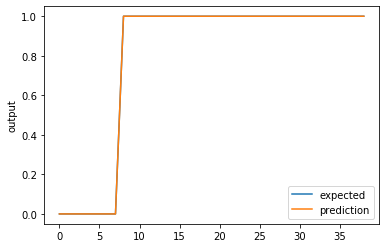

In [103]:
reg_chart(pred.flatten(),y_test)